## 1. Introduction

The idea of today's workshop learn about Bayesian statistical methods and Markov Chain Monte Carlo (MCMC) methods. We will focus on bridging the gap between textbook examples and the actual application of these methods to your research.

<br>

In particular, we will learn about:

* `01-introduction`: Bayesian statistical methods & MCMC
* `02-model-building`: Going from a science question to a statistical model
* `03-model-checking`: Diagnosing problems in models and computation

### A note on context

<br>

In this short course, we will *not* learn about **frequentist** statistical methods or **machine learning** approaches, which are both things you have probably heard of and may be interested in using in your research. While I might make fun of them a bit below, there are certainly cases where these could be more appropriate than what we will focus on.

So, before jumping into the Bayesian workflow, I'll try to *briefly* highlight some similarities and differences between these topics, from the Bayesian perspective.

<br>

Let's start by recalling Bayes' theorem with data, $x$, and model parameters $\theta$:

<br>

<img src="figures/bayes_theorem.png" width="700"/>

<br>

<u>Frequentist methods</u> 

We can start to think about some differences between Bayesian and frequentist statistical views by studying the following xkcd comic:

<br>

<img src="https://imgs.xkcd.com/comics/frequentists_vs_bayesians.png" width="350"/>

<br>

Both approaches involve a likelihood - $p(\mathrm{answer}~|~\mathrm{sun~status})$. For this problem, the probability of the machine saying "yes" given the sun has *not* exploded is equal to the probablity of rolling two sixes, i.e.

$$
p(\mathrm{yes}~|~\mathrm{sun~ok}) = 1/36, \\
p(\mathrm{yes}~|~\mathrm{sun~exploded}) = 35/36.
$$

One frequentist approach would be to perform a *hypothesis test*, with the null hypothesis being "sun ok" and the alternative hypothesis being "sun exploded". The *p-value* is the probability that we observe a result as least as extreme as that observed, under the null hypothesis. In this case, that is equal to the first statement above. In many fields, it is standard to reject the null hypothesis if the p-value is < 0.05, leading us to conclude the sun has exploded...

>**Note:** In physics it is common use a much stronger threshold for null hypothesis rejection such as "5 sigma", or a p-value lower than 0.0000001, so we would not lose a bet with a Bayesian this time. 

But on the Bayesian side, we would compute the posterior probability, $p(\mathrm{sun~exploded}~|~\mathrm{yes})$, proportional on the prior probability, $p(\mathrm{sun~exploded})$, which we would probably assume to be so tiny it would dominate our conclusion that the sun has not in fact exploded. 

<br>

So is frequentist statistics just Bayesian statistics without priors? Unfortunately, it is not so simple. Sure, we can think about the cases where they might seem equivalent. In frequentist approaches it is typical to find the *maximum likelihood estimate* of a parameter based on data. Could this be the same as the *maximum a posterior* value of a parameter for a uniform prior? 

However, it is important to keep in mind the different definitions of probability that the two views are based on: probability as a *degree of belief* vs. probability as a *frequency in the limit of infinte observations*. This also comes into the treatment of uncertainty. In the Bayesian view, **the data are fixed and parameters are uncertain**, whereas in the frequentist case, **the true parameters are fixed, and we estimate them imperfectly due to uncertainty present in the data from finite sampling**.

<u>Machine learning</u>

Machine learning is used to describe basically anything these days, but here I am referring to methods based on neural networks.

<br>

<img src="https://imgs.xkcd.com/comics/machine_learning.png" width="350"/>

<br>

We can think about standard machine learning approaches as similar to maximum likelihood estimation. If we don't know what the likelihood looks like, or cannot come up with a functional form for it, we can choose to represent it as a matrix of unknown weights.

We can then *train* a neural network with simulated or labelled data in order to *learn* the appropriate weights, an optimisation process that can be thought of as maximising the likelihood. Once trained, the resulting matrix of weights can be used like an operator to return the maximum likelihood estimate for new input data. 

A key difference in this approach is that the likelihood itself is now a *black box*, and so **it is not so clear how we should interpret our model or the resulting inferences**. **The quantification of uncertainty is also not straightforward**. This is fine if you just want to make classifications or predictions, without asking why. That said, there is plenty of work being done on ways to interpret neural networks and methods exist to bring more Bayesian thinking in and allow uncertainty quantification. 

### Are you ready?

We will be using the [Stan](https://mc-stan.org) statistical programming language to demonstrate a Bayesian workflow. In particular, we will use Stan's implementation of *Hamiltonian Monte Carlo* (HMC) through the `cmdstanpy` python interface. 

To start with, we will make sure everything is working by simulating some data from a normal distribution and verifying that we can fit the parameters of this distribution using `cmdstanpy`.

In [1]:
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
from cmdstanpy import CmdStanModel
import arviz as av

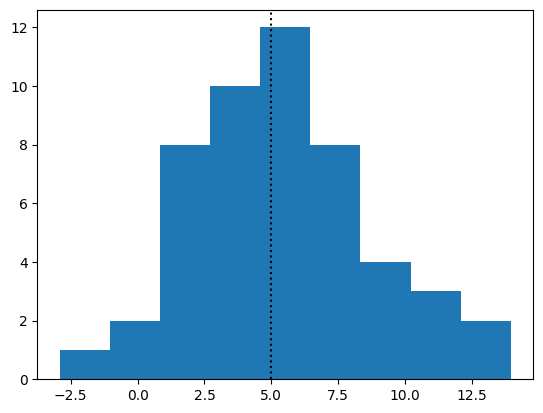

In [2]:
# simulate some data from a normal distribution
N = 50
mu = 5
sigma = 3
x = stats.norm(loc=mu, scale=sigma).rvs(N)

# plot histogram
fig, ax = plt.subplots()
ax.hist(x, bins=np.linspace(min(x), max(x), 10))
ax.axvline(mu, color="k", linestyle=":")

To fit this data with Stan to try and recover `mu` and `sigma`, we need to write our model in the Stan language. More details can be found in the [Stan user's guide](https://mc-stan.org/docs/2_27/stan-users-guide/index.html). The model for normal-distributed data looks like this:

```cpp
data{
    int N;
    vector[N] x;
}

parameters { 
    real mu;
    real<lower=0> sigma;
}

model {
    x ~ normal(mu, sigma);
}
```
>NB: by not specifying priors on the parameters `mu` and `sigma`, we implicitly define uniform priors over +/- infinity, or within the bounds given by `<lower=L, upper=U>`. 

You can find this model in the file `stan/normal.stan`. 

In [3]:
# compile the Stan model
stan_model = CmdStanModel(stan_file="stan/normal.stan")

print(stan_model)

CmdStanModel: name=normal
	 stan_file=/Users/Capel/projects/jAG25-workshop/stan/normal.stan
	 exe_file=/Users/Capel/projects/jAG25-workshop/stan/normal
	 compiler_options=stanc_options={}, cpp_options={}


In [4]:
# put data in dict to pass to the CmdStanModel
# the keys have to match the variable names in the Stan file data block
data = {}
data["N"] = N
data["x"] = x

# run HMC for 1000 iterations with 4 chains
fit = stan_model.sample(data=data, iter_sampling=1000, chains=4)

# check the results
fit.summary()

12:30:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:30:17 - cmdstanpy - INFO - CmdStan done processing.


,Mean,MCSE,StdDev,MAD,5%,50%,95%,ESS_bulk,ESS_tail,R_hat
lp__,-85.03410,0.028158,1.064710,0.731885,-87.07460,-84.70060,-84.03940,1704.19,2009.03,1.00051
mu,5.40073,0.010424,0.494392,0.478887,4.59118,5.39373,6.21707,2302.99,1953.30,1.00160
sigma,3.45509,0.007716,0.370618,0.359286,2.91289,3.42045,4.10263,2536.50,2425.00,1.00181


In [5]:
# check diagnostics
fit.diagnose();

5.400733955
(4000,)


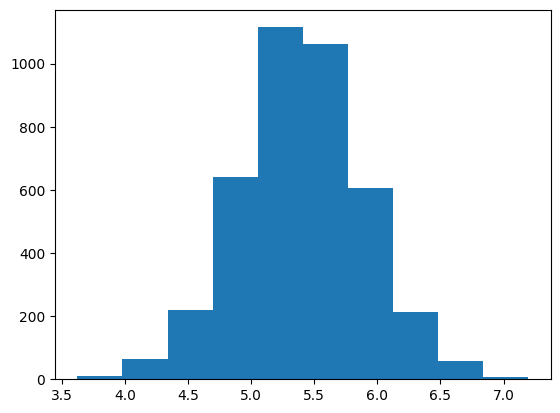

In [6]:
# access parameter chains
mu_chain = fit.stan_variable("mu")

fig, ax = plt.subplots()
ax.hist(mu_chain)

print(np.mean(mu_chain))
print(np.shape(mu_chain)) # 1000 iterations x 4 chains

In [7]:
# access all parameter chains in dict
fit.stan_variables()

{'mu': array([5.63477, 5.48664, 5.44806, ..., 5.55358, 5.35157, 5.99685],
       shape=(4000,)),
 'sigma': array([3.38601, 3.47374, 3.42115, ..., 3.5619 , 3.26903, 3.07079],
       shape=(4000,))}

In [8]:
# access all chains and sample info
# e.g. lp__: log posterior value
# Don't worry too much about all the names with underscores__
fit.draws_pd()

,chain__,iter__,draw__,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,mu,sigma
0,1.0,1.0,1.0,-84.1021,1.000000,0.701964,2.0,3.0,0.0,84.4660,5.63477,3.38601
1,1.0,2.0,2.0,-84.0456,1.000000,0.701964,2.0,3.0,0.0,84.1350,5.48664,3.47374
2,1.0,3.0,3.0,-84.0011,0.991869,0.701964,2.0,3.0,0.0,84.1442,5.44806,3.42115
3,1.0,4.0,4.0,-84.0826,0.973564,0.701964,1.0,3.0,0.0,84.2985,5.30306,3.24030
4,1.0,5.0,5.0,-84.1900,0.967592,0.701964,3.0,7.0,0.0,84.5280,5.13958,3.48999
...,...,...,...,...,...,...,...,...,...,...,...,...
3995,4.0,996.0,3996.0,-84.9485,0.994460,0.667375,3.0,7.0,0.0,84.9770,4.76118,3.30426
3996,4.0,997.0,3997.0,-84.2342,0.999272,0.667375,2.0,3.0,0.0,85.0949,5.39152,3.62208
3997,4.0,998.0,3998.0,-84.1783,0.980125,0.667375,2.0,3.0,0.0,84.5833,5.55358,3.56190
3998,4.0,999.0,3999.0,-84.0344,0.958029,0.667375,1.0,3.0,0.0,84.8779,5.35157,3.26903


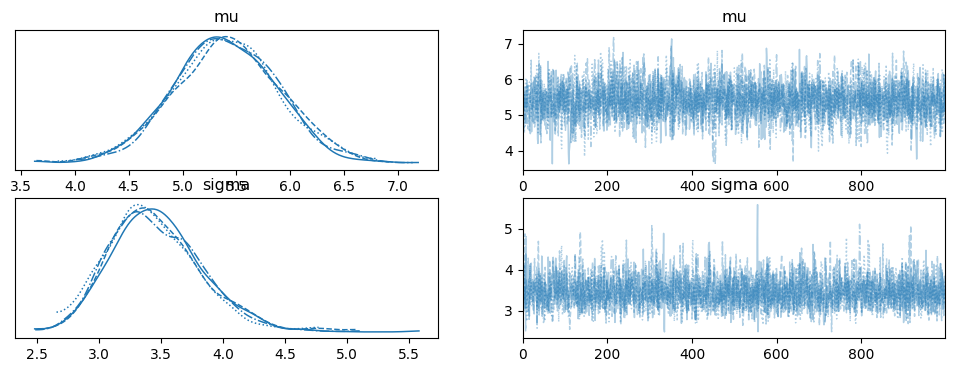

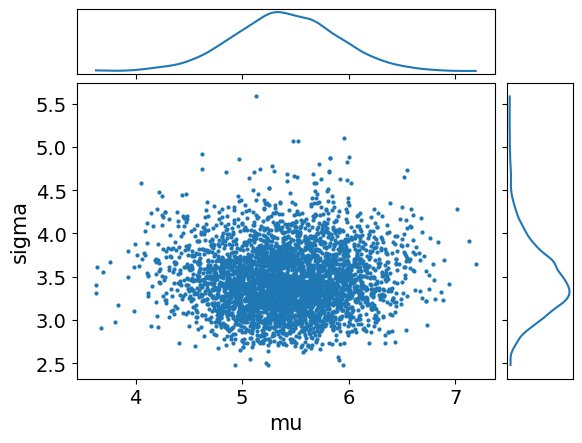

In [9]:
# use arviz to visualise the results if you like, it has common functionality built in
av.plot_trace(fit);

av.plot_pair(fit, marginals=True);

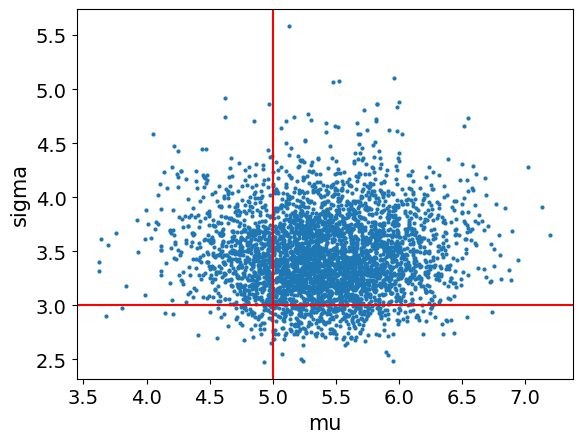

In [10]:
# the av.plot.. calls return an axis that you can continue plotting on
ax = av.plot_pair(fit, var_names=["mu", "sigma"])
ax.axvline(mu, color="r")
ax.axhline(sigma, color="r")

<Axes: xlabel='mu', ylabel='sigma'>

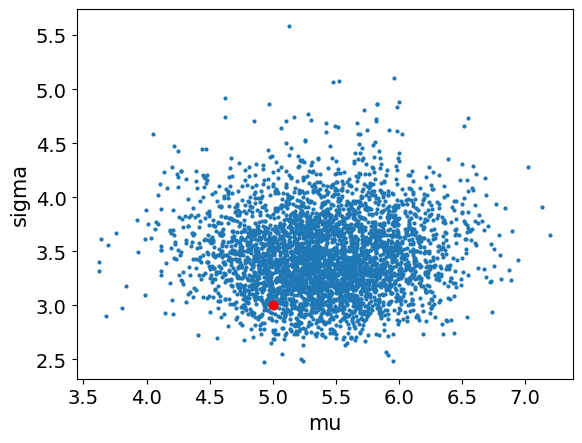

In [11]:
# or you can pass them an axis
fig, ax = plt.subplots()
ax.scatter(mu, sigma, color="r")
av.plot_pair(fit, var_names=["mu", "sigma"], ax=ax)

Ok, so it looks like everything is up and running. You can try changing the input data and see how the results change accordingly. Let's investigate a few specific cases in the exercise below.

<br>

**Exercise 1:** 

What happens to the shape of the marginal distributions in the following cases: 

* Very little data (small `N`) 
* Large amounts of data (large `N`)
* Narrow priors on `mu` and `sigma`

Make plots to summarise the comparison with the original case. What differences can be seen with what we might expect from a point estimate of these parameters using e.g. maximum likelihood.

<span style="color:green">**Exercise 1 solution**</span>

<span style="color:green">First let's compare different sample sizes.</span>


In [13]:
N = [1, 5, 50, 1000]
fits = []

for n in N:
    x = stats.norm(loc=mu, scale=sigma).rvs(n)
    data = {}
    data["N"] = n
    data["x"] = x
    fit = stan_model.sample(data=data, iter_warmup=1000, iter_sampling=1000, chains=4)
    fits.append(fit)

12:31:47 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:31:47 - cmdstanpy - INFO - CmdStan done processing.
12:31:47 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'normal.stan', line 12, column 4 to column 26)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'normal.stan', line 12, column 4 to column 26)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'normal.stan', line 12, column 4 to column 26)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'normal.stan', line 12, column 4 to column 26)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'normal.stan', line 12, column 4 to column 26)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'normal.stan', line 12, column 4 to column 26)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'normal.stan', line 12, column 4 to column 26)
	Exception: normal_lpdf: Scale parameter 

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:31:48 - cmdstanpy - INFO - CmdStan done processing.
12:31:48 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:31:48 - cmdstanpy - INFO - CmdStan done processing.
12:31:48 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:31:48 - cmdstanpy - INFO - CmdStan done processing.
12:31:48 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'normal.stan', line 12, column 4 to column 26)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'normal.stan', line 12, column 4 to column 26)
Consider re-running with show_console=True if the above output is unclear!


<span style="color:green">We should notice that extremely low sample numbers lead to issues with sampling, this just reflects that it is difficult to estimate the mean of a distribution based on so little information. Note that we also didn't provide any priors...</span>

In [15]:
print(fits[0].diagnose())
fits[0].summary()

Checking sampler transitions treedepth.
190 of 1000 (19.00%) transitions hit the maximum treedepth limit of 10, or 2^10 leapfrog steps.
Trajectories that are prematurely terminated due to this limit will result in slow exploration.
For optimal performance, increase this limit.

Checking sampler transitions for divergences.
3523 of 1000 (352.30%) transitions ended with a divergence.
These divergent transitions indicate that HMC is not fully able to explore the posterior distribution.
Try increasing adapt delta closer to 1.
If this doesn't remove all divergences, try to reparameterize the model.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Rank-normalized split effective sample size satisfactory for all parameters.

The following parameters had rank-normalized split R-hat greater than 1.01:
  mu
Such high values indicate incomplete mixing and biased estimation.
You should consider regularizating your model with additional prior information or a more 

,Mean,MCSE,StdDev,MAD,5%,50%,95%,ESS_bulk,ESS_tail,R_hat
lp__,-1.160730e-04,NaN,2.183540e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN
mu,9.814190e+12,9.208820e+12,1.357250e+13,4.454950e+12,-1.427110e+12,1.045240e+12,3.771000e+13,4.96912,2000.000,2.38282
sigma,inf,inf,inf,5.125420e+163,1.901220e+28,3.457050e+163,4.153710e+295,604.08200,915.345,1.00602


<span style="color:green">Things already improve a lot for N=5! Have a look below. Let's take this as our minimum, and plot the marginal posteriors for `mu` and `sigma`.</span>

In [16]:
fits[1].diagnose();
fits[1].summary()

,Mean,MCSE,StdDev,MAD,5%,50%,95%,ESS_bulk,ESS_tail,R_hat
lp__,-6.30105,0.052270,1.33009,0.954016,-8.97241,-5.89141,-5.01889,820.984,776.280,1.00480
mu,7.04920,0.071508,1.89701,1.243660,4.29482,7.12864,9.65015,1017.340,810.981,1.00707
sigma,3.33095,0.084464,2.15214,1.217840,1.49860,2.75235,6.92580,904.896,835.076,1.00332


Text(0.5, 0, 'sigma')

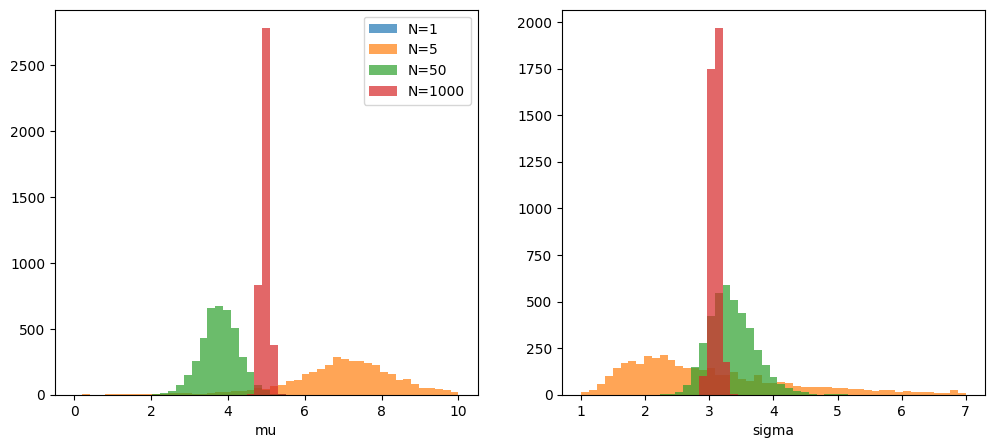

In [17]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches((12, 5))

bins_mu = np.linspace(0, 10)
bins_sigma = np.linspace(1, 7)

for n, fit in zip(N, fits):
    ax[0].hist(fit.stan_variable("mu"), bins=bins_mu, alpha=0.7, label="N=%i"%n)
    ax[1].hist(fit.stan_variable("sigma"), bins=bins_sigma, alpha=0.7, label="N=%i"%n)

ax[0].legend()
ax[0].set_xlabel("mu")
ax[1].set_xlabel("sigma")

<span style="color:green">So we see that increasing the amount of data clearly leads to tighter constraints of the values of the parameters that we want to estimate. It is intuitive that with less information there is more uncertainty. The factor would be less obvious if we were just using a point estimate, such as the maximum likelihood estimate. Next, let's consider some narrow priors. Let's take two cases: narrow priors centred on true values, and narrow priors centred elsewhere (see Stan files for details). In both cases, we can use N=50 to compare with our original case of implicit uniform priors. 
</span>

In [18]:
stan_files = ["stan/normal.stan", "stan/normal_prior_true.stan",
              "stan/normal_prior_false.stan"]
N = 50
data = {}
data["N"] = N
data["x"] = stats.norm(loc=mu, scale=sigma).rvs(N)

fits = []
for sf in stan_files:
    stan_model = CmdStanModel(stan_file=sf)
    fit = stan_model.sample(data=data, iter_sampling=1000, chains=4)
    fits.append(fit)

12:36:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:36:18 - cmdstanpy - INFO - CmdStan done processing.
12:36:18 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'normal.stan', line 12, column 4 to column 26)
Consider re-running with show_console=True if the above output is unclear!
12:36:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:36:18 - cmdstanpy - INFO - CmdStan done processing.
12:36:18 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'normal_prior_true.stan', line 15, column 2 to column 24)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'normal_prior_true.stan', line 15, column 2 to column 24)
Consider re-running with show_console=True if the above output is unclear!
12:36:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:36:19 - cmdstanpy - INFO - CmdStan done processing.
12:36:19 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'normal_prior_false.stan', line 15, column 2 to column 24)
Consider re-running with show_console=True if the above output is unclear!


Text(0.5, 0, 'sigma')

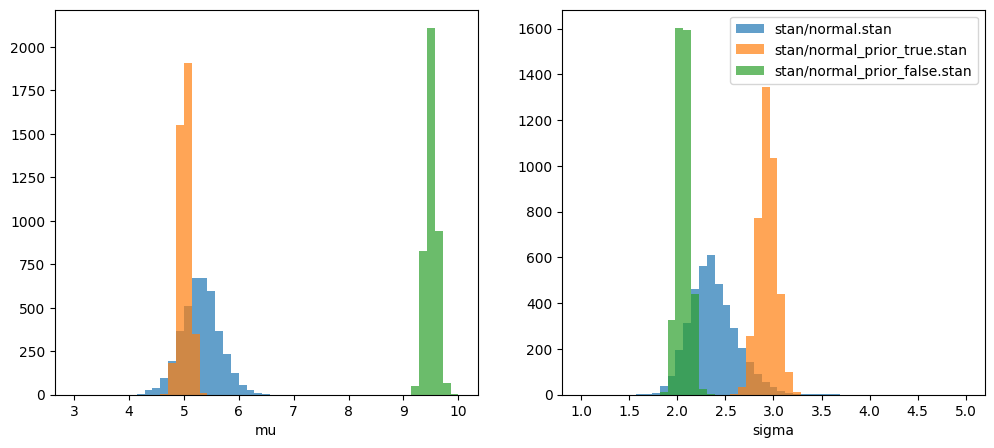

In [19]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12, 5)

bins_mu = np.linspace(3, 10)
bins_sigma = np.linspace(1, 5)

for sf, fit in zip(stan_files, fits):
    ax[0].hist(fit.stan_variable("mu"), bins=bins_mu, alpha=0.7, label=sf)
    ax[1].hist(fit.stan_variable("sigma"), bins=bins_sigma, alpha=0.7, label=sf)
ax[1].legend()
ax[0].set_xlabel("mu")
ax[1].set_xlabel("sigma")

### Workflow overview

<br>

As we just saw above, building and fitting Bayesian model can be very easy with the tools available to us. However, for most scientific problems of interest, we won't be dealing with idealised observations of normally-distributed data. The situation is to start out with **data** and a **question**. There is no simple recipe to go from this starting point to completing your analysis and drawing robust **conclusions**, but the idea of the workflow that we will discuss today is to present a general strategy for doing so. 

<br>

<img src="figures/workflow0.png" alt="The workflow!" width="600"/>

<br>

The workflow itself is made up of many different components and iterative processes. We want to start by using our question and data to define a **meaningful statistical model**. This stage often involves some form of **exploratory data analysis** and/or **generative modelling**. Once we have defined our model, we want to **check** if it makes sense or needs improvement. We therefore iterate through **model development** and **implementation** until we are satisfied. Our final model can be used to **draw conclusions** via **inference**. With the final model in hard, we can also think about performing **model comparison** with other models, or using the model to inform better **experiment design** in the future. 

<br>

<img src="figures/workflow1.png" alt="The workflow!" width="800"/>

<br>

### Some more fun with Stan

Let's consider a simple linear regression problem. We observe a variable $y$ that is related to a known quantity $x$ via
$$
y = mx + c,
$$
where $m$ and $c$ are the unknown slope and intercept, to be determined. Our observation process introduces uncertainty, such that 
$$
\hat{y} \sim \mathcal{N}(y, \sigma),
$$
where $\sigma$ is a known quantity that is constant for all observations.


**Exercise 2:** Write a Stan model for the above model, considering the dataset introduced below. Verify that it compiles.

Text(0, 0.5, 'y')

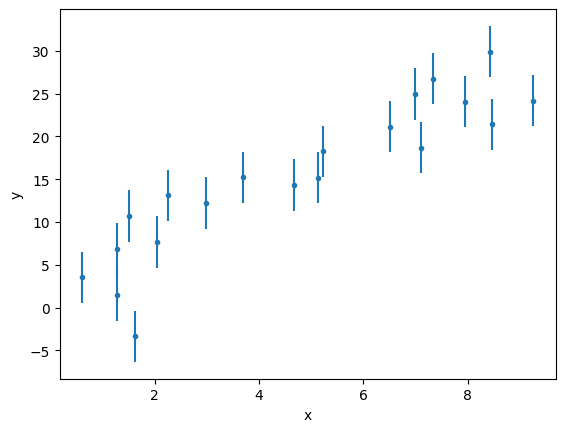

In [20]:
# load data
data = np.loadtxt("data/linear.dat")
x_obs = data[0]
y_obs = data[1]
sigma = data[2][0] # all the same

# plot
fig, ax = plt.subplots()
ax.errorbar(x_obs, y_obs, yerr=sigma, fmt=".")
ax.set_xlabel("x")
ax.set_ylabel("y")

<span style="color:green">**Exercise 2 solution:**</span>

In [21]:
!cat stan/line_fit.stan

data{

  int N;
  vector[N] x_obs;
  vector[N] y_obs;
  real sigma;
}

parameters { 

  real m;
  real c;

}

transformed parameters {

  vector[N] y;

  y = m * x_obs + c;
  
}

model {
  
  y_obs ~ normal(y, sigma);

}


In [22]:
stan_model = CmdStanModel(stan_file="stan/line_fit.stan")

**Exercise 3:** Build a dictionary to pass the data to Stan and fit the model. Visualise your results for $m$ and $c$.

<span style="color:green">**Exercise 3 solution:**</span>

In [23]:
data = {}
data["N"] = len(x_obs)
data["x_obs"] = x_obs
data["y_obs"] = y_obs
data["sigma"] = sigma

fit = stan_model.sample(data=data, iter_sampling=1000, chains=4)

12:40:40 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:40:40 - cmdstanpy - INFO - CmdStan done processing.


In [25]:
print(fit.diagnose())
fit.summary()

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Rank-normalized split effective sample size satisfactory for all parameters.

Rank-normalized split R-hat values satisfactory for all parameters.

Processing complete, no problems detected.



,Mean,MCSE,StdDev,MAD,5%,50%,95%,ESS_bulk,ESS_tail,R_hat
lp__,-15.80070,0.030512,1.041660,0.697712,-17.784400,-15.48550,-14.85280,1287.740,1796.720,1.001820
m,2.81111,0.007678,0.235836,0.240700,2.434810,2.81234,3.19218,952.547,1128.610,1.003640
c,2.04616,0.042908,1.291250,1.281970,-0.045807,2.06539,4.11429,923.719,940.038,1.002130
y[1],21.69580,0.016370,0.870369,0.864801,20.296600,21.67080,23.14610,2865.510,2593.420,1.001060
y[2],22.03320,0.017093,0.888468,0.883037,20.589700,22.00670,23.50370,2736.590,2502.550,1.000870
y[3],10.42330,0.021075,0.784114,0.767913,9.121080,10.42270,11.68770,1410.500,1776.770,1.000660
y[4],7.80894,0.027707,0.915020,0.900064,6.296010,7.81596,9.28573,1112.400,1311.910,1.001300
y[5],16.72020,0.010551,0.688502,0.675547,15.608800,16.71180,17.87840,4255.550,3319.040,1.000200
y[6],6.29094,0.031658,1.005270,1.009110,4.637660,6.29298,7.90849,1027.940,1229.100,1.001620
y[7],22.65160,0.018463,0.922986,0.913652,21.149100,22.62440,24.18050,2528.410,2502.200,1.000900


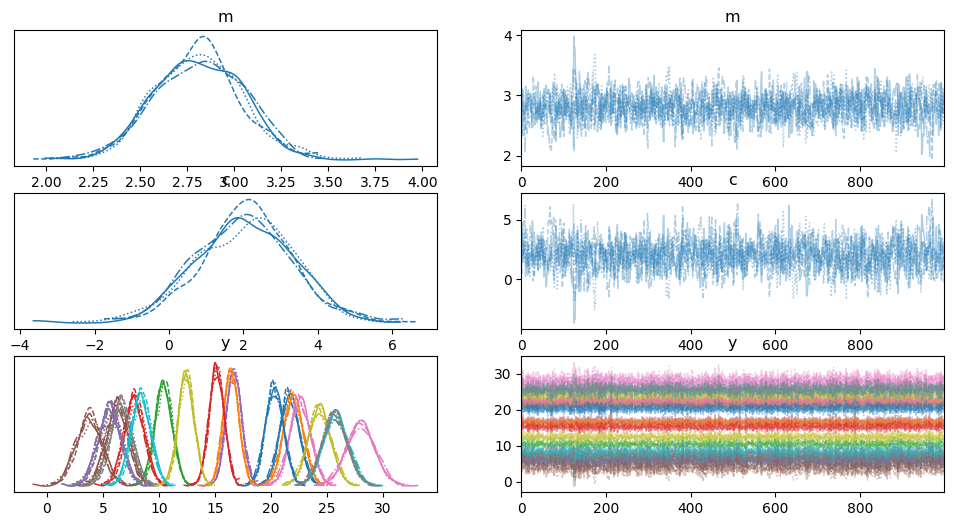

In [26]:
av.plot_trace(fit);

**Exercise 4:** We now learn that the $x$ observations also have an associated uncertainty, $\tau$, such that
$$
\hat{x} \sim \mathcal{N}(x, \tau)
$$
We are told that $\tau = 1$. Update your Stan model to include this information and repeat the fit to data. How does this affect our results for the line fit?

<span style="color:green">**Exercise 4 solution:**</span>

In [27]:
!cat stan/line_fit_xerr.stan

data{

  int N;
  vector[N] x_obs;
  vector[N] y_obs;
  real sigma;
  real tau;

}

parameters { 

  real m;
  real c;

  vector[N] x;
  
}

transformed parameters {

  vector[N] y;
  
  y = m * x + c;
  
}

model {

  x_obs ~ normal(x, tau);
  y_obs ~ normal(y, sigma);
  
  
}


In [28]:
stan_model = CmdStanModel(stan_file="stan/line_fit_xerr.stan")

In [29]:
data = {}
data["N"] = len(x_obs)
data["x_obs"] = x_obs
data["y_obs"] = y_obs
data["sigma"] = sigma
data["tau"] = 1

fit_xerr = stan_model.sample(data=data, iter_sampling=1000, chains=4)

12:44:40 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:44:40 - cmdstanpy - INFO - CmdStan done processing.


In [30]:
fit_xerr.diagnose()
fit_xerr.summary()

,Mean,MCSE,StdDev,MAD,5%,50%,95%,ESS_bulk,ESS_tail,R_hat
lp__,-18.872500,0.091597,3.436660,3.338070,-24.994100,-18.584000,-13.83510,1471.01,2292.26,1.000750
m,2.802420,0.006553,0.313866,0.311605,2.308490,2.787570,3.34768,2378.50,2788.55,1.000310
c,2.105410,0.034912,1.737940,1.701050,-0.893246,2.158730,4.88345,2518.03,2642.84,1.000680
x[1],7.533270,0.009670,0.747388,0.742923,6.337800,7.506400,8.79623,6129.44,3135.41,0.999794
x[2],6.570000,0.009417,0.749986,0.756015,5.330680,6.573430,7.80800,6351.25,2800.23,1.000420
x[3],3.276460,0.009289,0.746292,0.752331,2.031570,3.279670,4.51855,6491.16,3059.60,1.001410
x[4],2.031580,0.009615,0.743842,0.731174,0.790892,2.044540,3.22386,6025.68,2687.83,1.000700
x[5],5.472760,0.008797,0.754238,0.750136,4.237460,5.479430,6.73419,7451.04,3031.29,1.000710
x[6],2.231650,0.010583,0.755419,0.752560,0.960846,2.242200,3.44165,5164.36,2876.01,1.001170
x[7],8.010390,0.008683,0.754402,0.757446,6.806010,7.996770,9.26086,7680.90,3207.91,1.002210


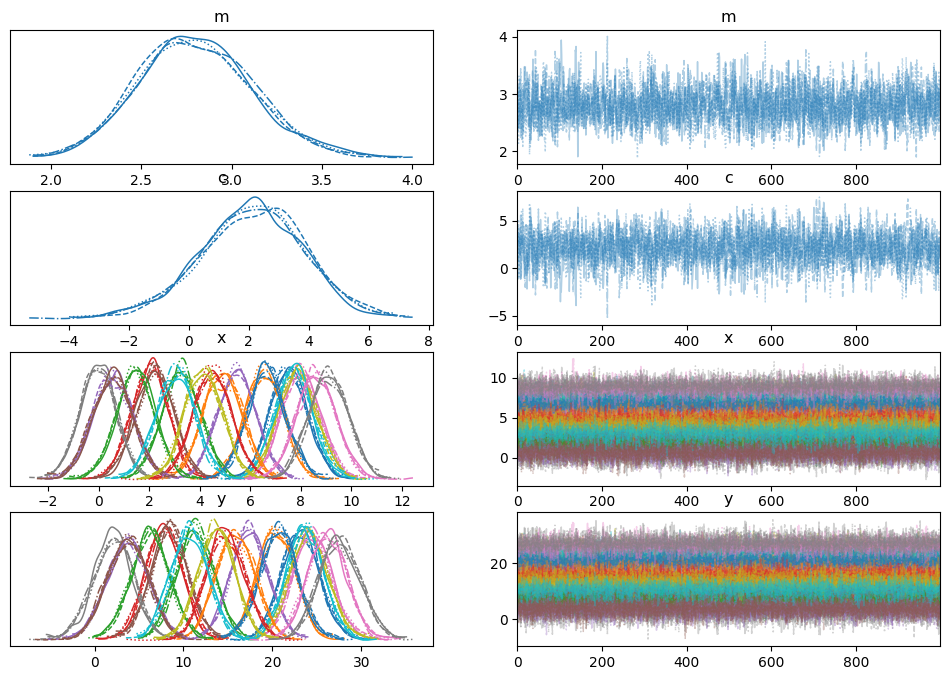

In [31]:
av.plot_trace(fit_xerr);

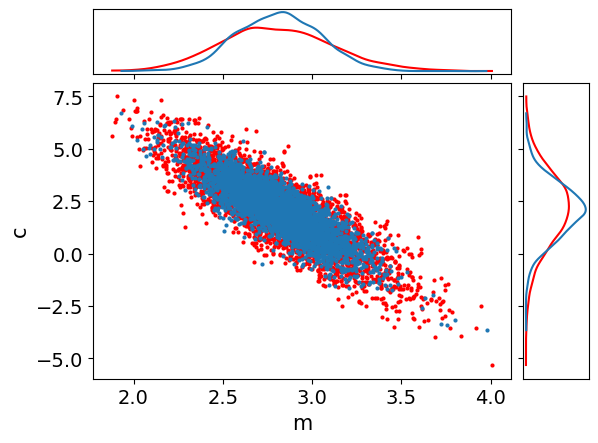

In [32]:
ax = av.plot_pair(fit_xerr, var_names=["m", "c"], marginals=True, 
                  scatter_kwargs={"color": "r"}, marginal_kwargs={"color": "r"})
ax = av.plot_pair(fit, var_names=["m", "c"], marginals=True, ax=ax)

<span style="color:green">We see that introducing the uncertainty on the x locations adds a more uncertainty to our joint distribution of `m` and `c`.</span>